In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import re
import warnings
from datetime import datetime, timedelta
from collections import defaultdict
import glob
from fuzzywuzzy import process
from bs4 import BeautifulSoup
import networkx as nx
from networkx.algorithms import bipartite
from community import community_louvain
import requests
import json
import urllib.request

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.book import *
from wordcloud import WordCloud
import requests
import warnings
from datetime import datetime, timedelta
from collections import defaultdict



/Users/simon/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:
# create funtions to get the data from football-API
def getLeagues():
    '''
    This function returns a pandas dataframe with all leagues and their IDs
    Notice: the league_name is not unique, but the league_id is
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/leagues'
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers)

    leagues = response.json()['response']

    df = pd.DataFrame(columns=['league_id', 'league_name'])
    for league in leagues:
        df = df.append({'league_id': league['league']['id'], 'league_name': league['league']['name']}, ignore_index=True)
    
    return df

def getTeams(league_id, year='2022'):
    '''
    This function returns a pandas dataframe with all teams and their IDs
    Input: league_id, (year)
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/teams'
    params = {'league': str(league_id), 'season': str(year)}
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers, params=params)
    teams = response.json()['response']

    df = pd.DataFrame(columns=['team_id', 'team_name'])
    for team in teams:
        df = df.append({'team_id': team['team']['id'], 'team_name': team['team']['name']}, ignore_index=True)
    return df

def getteamsforcountry(country):
    '''
    This function returns a pandas dataframe with all teams and their IDs
    Input: league_id, (year)
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/leagues'
    params = {'country': str(country)}
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers, params=params)
    teams = response.json()['response']
    # convert teams to pandas dataframe
    df = pd.DataFrame(columns=['league_id', 'team_name'])
    for team in teams:
        df = df.append({'league_id': team['league']['id'], 'team_name': team['league']['name']}, ignore_index=True)
    return df
    



def getMatches(league_id, team_id, year='2022'):
    '''
    This function returns a pandas dataframe with all matches of a team in a league
    Input: league_id, team_id, (year)
    '''
    print("Trying to fetch matches for team_id: " + str(team_id) + " and league_id: " + str(league_id))
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/fixtures'
    params = {'league': str(league_id), 'season': str(year), 'team': str(team_id)}
    headers = {
        "X-RapidAPI-Key": "b488e0c68amsh64a0fa30d4a8df1p16e1a6jsn1f268e40bf08",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    # if response is not 200, print error message
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error: " + response.json()['message'])
        return None
    df = pd.DataFrame(columns=['fixture_id', 'home_team_id', 'away_team_id', 'goals', 'timezone', 'date', 'timestamp', 'first_half', 'second_half'])
    for fixture in response.json()['response']:
        fixture_id = fixture['fixture']['id']
        home_team_id = fixture['teams']['home']['id']
        away_team_id = fixture['teams']['away']['id']
        goals = fixture['goals']
        timezone = fixture['fixture']['timezone']
        date = fixture['fixture']['date']
        timestamp = fixture['fixture']['timestamp']
        periods = fixture['fixture']['periods']
        first_half = periods['first']
        second_half = periods['second']
        df = df.append({'fixture_id': fixture_id, 'home_team_id': home_team_id, 'away_team_id': away_team_id, 'goals': goals, 'timezone': timezone, 'date': date, 'timestamp': timestamp, 'first_half': first_half, 'second_half': second_half}, ignore_index=True)
    
    df['home_team_goals'] = df['goals'].apply(lambda x: x['home'])
    df['away_team_goals'] = df['goals'].apply(lambda x: x['away'])
    df = df.dropna(subset=['home_team_goals', 'away_team_goals'])
    df = df.drop(columns=['goals'])
    
    return df

def getEvents(fixture_id):
    print("Trying to fetch events for fixture_id: " + str(fixture_id))
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/fixtures/events'
    headers = {
        "X-RapidAPI-Key": "b488e0c68amsh64a0fa30d4a8df1p16e1a6jsn1f268e40bf08",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    params = {'fixture': str(fixture_id)}
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error: " + response.json()['message'])
        return None
    
    # convert to pandas dataframe
    df = pd.DataFrame(response.json()['response'])
    
    # manipulate dataframe
    df['elapsed_time'] = df['time'].apply(lambda x: x['elapsed'])
    df = df.drop(columns=['time'])
    df['team_id'] = df['team'].apply(lambda x: x['id'])
    df['team_name'] = df['team'].apply(lambda x: x['name'])
    df['player_id'] = df['player'].apply(lambda x: x['id'])
    df['player_name'] = df['player'].apply(lambda x: x['name'])
    df = df.drop(columns=['team', 'player', 'assist'])
    df = df[df['type'] == 'Goal']

    return df

def get_all_goals_with_timestamps(league_id, team_id, year='2022'):
    warnings.filterwarnings("ignore")
    matches = getMatches(league_id, team_id, year)
    # if no rows in matches, return None
    if matches.shape[0] == 0:
        print("No matches found for team_id: " + str(team_id) + " and league_id: " + str(league_id))
        return None
    allGoals = defaultdict(lambda: '')
    for index, row in matches.iterrows():
        fixture_id = row['fixture_id']
        goals = getEvents(fixture_id)
        # for each goal, check if elapsed time is in first or second half and add to allGoals
        for index, goal in goals.iterrows():
            if goal['elapsed_time'] <= 45:
                stamp = row['first_half'] + goal['elapsed_time']*60
                # variable that is used to check if the goal is scored by the home team or away team
                team = 'away' if goal['team_id'] != team_id else 'home'
                allGoals[stamp] = team
            else:
                stamp = row['second_half'] + goal['elapsed_time']*60
                # variable that is used to check if the goal is scored by the home team or away team
                team = 'away' if goal['team_id'] != team_id else 'home'
                allGoals[stamp] = team
    # convert defaultdict to dict
    return dict(allGoals)

def generate_tickers(eventTime, ticker):
    b = get_binance_data(datetime.utcfromtimestamp(eventTime), start_time=datetime.utcfromtimestamp(eventTime-(60*5)), end_time=datetime.utcfromtimestamp(eventTime+(60*6)), ticker=ticker)
    tickers = generate_timebars(b, frequency='10S')
    return tickers

def save_goal_charts(goals, ticker):
    for k, v in goals.items():
        goal_time = datetime.utcfromtimestamp(k)
        tick = generate_tickers(k, ticker)
        # make time column datetime and set as index
        tick['time'] = pd.to_datetime(tick['time'], unit='ms')
        tick = tick.set_index('time')
        try:
            mpl.plot(
                tick,
                type="candle",
                title = ticker,
                style="yahoo",
                vlines=dict(vlines=[goal_time],linewidths=(2)),
                savefig=dict(fname=f"charts/{ticker}_{goal_time}.png", dpi=300, pad_inches=0.25)
            )
        except:
            print("Error with chart for goal at: " + str(goal_time) + ". Skipping...")
    return True

def get_all_goal_charts(league_id, team_id, ticker, year='2022'):
    goals = get_all_goals_with_timestamps(league_id, team_id, year)
    if goals is None:
        return False
    goals = {k: v for k, v in goals.items() if v == 'home'}
    if len(goals) <= 1:
        return False
    save_goal_charts(goals, ticker)
    return True

In [3]:
# use funtion to get leagues
League_ids = getLeagues()

# save league ids to csv as we do not have unlimited calls
League_ids.to_csv('League_ids.csv', index=False)

# get all the teame names from the league ids manually due to limited calls 

teams_Ligue_1 = getTeams(61) # Ligue 1

# get the team names for Premier League

teams_Premier_League = getTeams(39) # Premier League

teams_Premier_League.to_csv('teams_Premier_League.csv', index=False)


In [4]:
#We did it for all leagues in the file called "All teams manually" and loaded all the files into a dataframe

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "teams_*.csv"))))
#df.to_csv('teams.csv', index=False)

In [5]:
df_league = pd.read_csv("teams.csv")
df_player = pd.read_csv("players.csv")
df_fifa = pd.read_csv("FIFA23_Cleaned.csv")

# Data Cleaning

In [6]:
#renmaing columns in league data
df_league = df_league.rename(columns={"team_name": "Club","country":"Leauge_country"})

In [7]:
#renameing and dropping columns in df_player
df_player = df_player.drop(['Unnamed: 0', 'No.', 'Date of birth (age)'], axis=1)# removing unnecessary 
df_player['Club2'] = df_player['Club'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_player =pd.DataFrame(df_player)
df_player =df_player.drop(['Club'], axis=1)
df_player = df_player.rename(columns={"Club2": "Club"})
#df_player

In [8]:
df_player[df_player['Player']=='Aymen Mathlouthi']

Pos.            Player  Caps  Goals  Country      Club
182   GK  Aymen Mathlouthi    73      0  Tunisia  ES Sahel

In [9]:
df_all = pd.merge(df_league, df_player, how = 'right', on='Club')
df_all

team_id              Club Leauge_country Pos.            Player  Caps  \
0     1156.0             Aucas        Equador   GK   Hernán Galíndez    12   
1     2285.0     Santos Laguna         Mexico   DF      Félix Torres    17   
2      168.0  Bayer Leverkusen        Germany   DF    Piero Hincapié    21   
3      126.0         Sao Paulo         Brazil   DF   Robert Arboleda    33   
4     1616.0    Los Angeles FC            USA   MF    José Cifuentes    11   
..       ...               ...            ...  ...               ...   ...   
825    492.0            Napoli          Italy   FW    Hirving Lozano    60   
826   2282.0         Monterrey         Mexico   DF    Jesús Gallardo    78   
827   2292.0           Pachuca         Mexico   MF       Luis Chávez     9   
828      NaN       Guadalajara            NaN   FW  Roberto Alvarado    31   
829   2292.0           Pachuca         Mexico   DF     Kevin Álvarez     8   

     Goals  Country  
0        0  Ecuador  
1        2  Ecuador  
2        1  Ecuador  
3        2  Ecuador  
4        0  Ecuador  
..     ...      ...  
825     16   Mexico  
826      1   Mexico  
827      0   Mexico  
828      4   Mexico  
829      0   Mexico  

[830 rows x 8 columns]

In [10]:
#inspecting why we get nan values for some of the players
#df_all[df_all.isna().any(axis=1)].head(50)

In [11]:
# finding the simalarities in the rows, based on the words that are similar. 
df_player['Club'] = df_player.apply(lambda x: process.extractOne(x['Club'], df_league['Club'])[0] if x['Club'] else None, axis=1)


In [12]:
#merging them together one more time. 
df1=pd.merge(df_player,df_league,on='Club')
df1[df1['Player']=='Simon Kjær (captain)']

Pos.                Player  Caps  Goals  Country      Club  team_id  \
303   DF  Simon Kjær (captain)   121      5  Denmark  AC Milan      489   

    Leauge_country  
303          Italy

In [13]:
df1.at[797,'Leauge_country']='UAE'

In [14]:
df1[df1['Player'].duplicated(keep=False)] # There are two Cho Yu-min for some reason. So we will drop one.

Pos.      Player  Caps  Goals      Country             Club  team_id  \
771   DF  Cho Yu-min     4      0  South Korea  Daejeon Citizen     2750   
772   DF  Cho Yu-min     4      0  South Korea  Daejeon Citizen     2750   

    Leauge_country  
771    South Korea  
772    South Korea

In [15]:
df1= df1.drop_duplicates().reset_index() # removing Cho 

# create copy of df1
df3 = df1.copy()

In [16]:
df1['Player'] = df1['Player'].str.replace(' \(captain\)', '')
df1['Player'] = df1['Player'].str.replace('æ', 'ae')
df1['Player'] = df1['Player'].str.replace('ø', 'oe')
df1['Player'] = df1['Player'].str.replace('å', 'aa')
#df1['Player'] = df1['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df1['WikiLink'] = df1['Player'].str.replace(' ', '_')
df1

index Pos.            Player  Caps  Goals      Country  \
0        0   GK   Hernán Galíndez    12      0      Ecuador   
1        1   DF      Félix Torres    17      2      Ecuador   
2        2   MF   Ayrton Preciado    27      3      Ecuador   
3        3   DF    Piero Hincapié    21      1      Ecuador   
4        4   DF  Jeremie Frimpong     0      0  Netherlands   
..     ...  ...               ...   ...    ...          ...   
825    826   DF    Jesús Gallardo    78      1       Mexico   
826    827   DF     Johan Vásquez     7      0       Mexico   
827    828   FW       Alexis Vega    22      6       Mexico   
828    829   FW  Roberto Alvarado    31      4       Mexico   
829    830   MF    Héctor Herrera   102     10       Mexico   

                   Club  team_id Leauge_country          WikiLink  
0                 Aucas     1156        Equador   Hernán_Galíndez  
1         Santos Laguna     2285         Mexico      Félix_Torres  
2         Santos Laguna     2285         Mexico   Ayrton_Preciado  
3      Bayer Leverkusen      168        Germany    Piero_Hincapié  
4      Bayer Leverkusen      168        Germany  Jeremie_Frimpong  
..                  ...      ...            ...               ...  
825           Monterrey     2282         Mexico    Jesús_Gallardo  
826           Cremonese      520          Italy     Johan_Vásquez  
827  Guadalajara Chivas     2278         Mexico       Alexis_Vega  
828  Guadalajara Chivas     2278         Mexico  Roberto_Alvarado  
829      Houston Dynamo     1600            USA    Héctor_Herrera  

[830 rows x 10 columns]

In [17]:
print(max(df1['Caps']))
print(min(df1['Caps']))

191
0


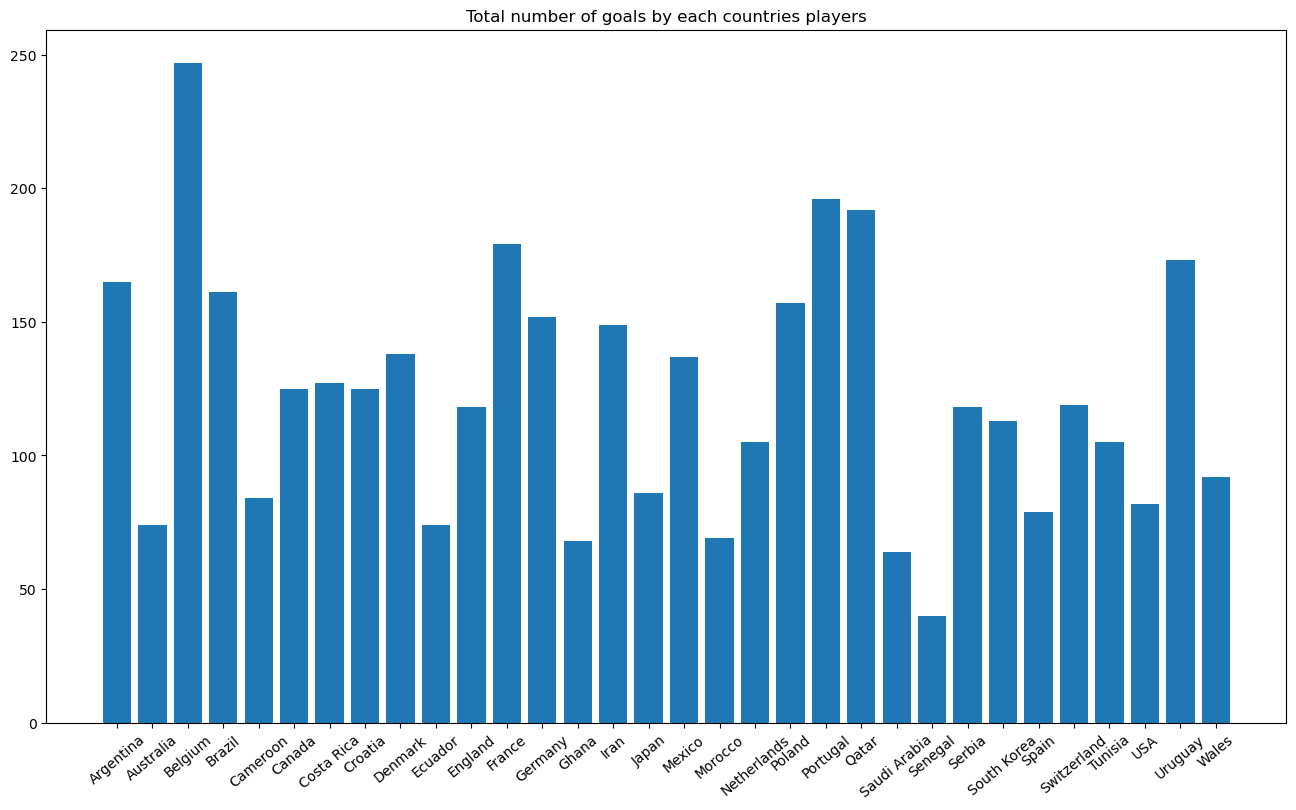

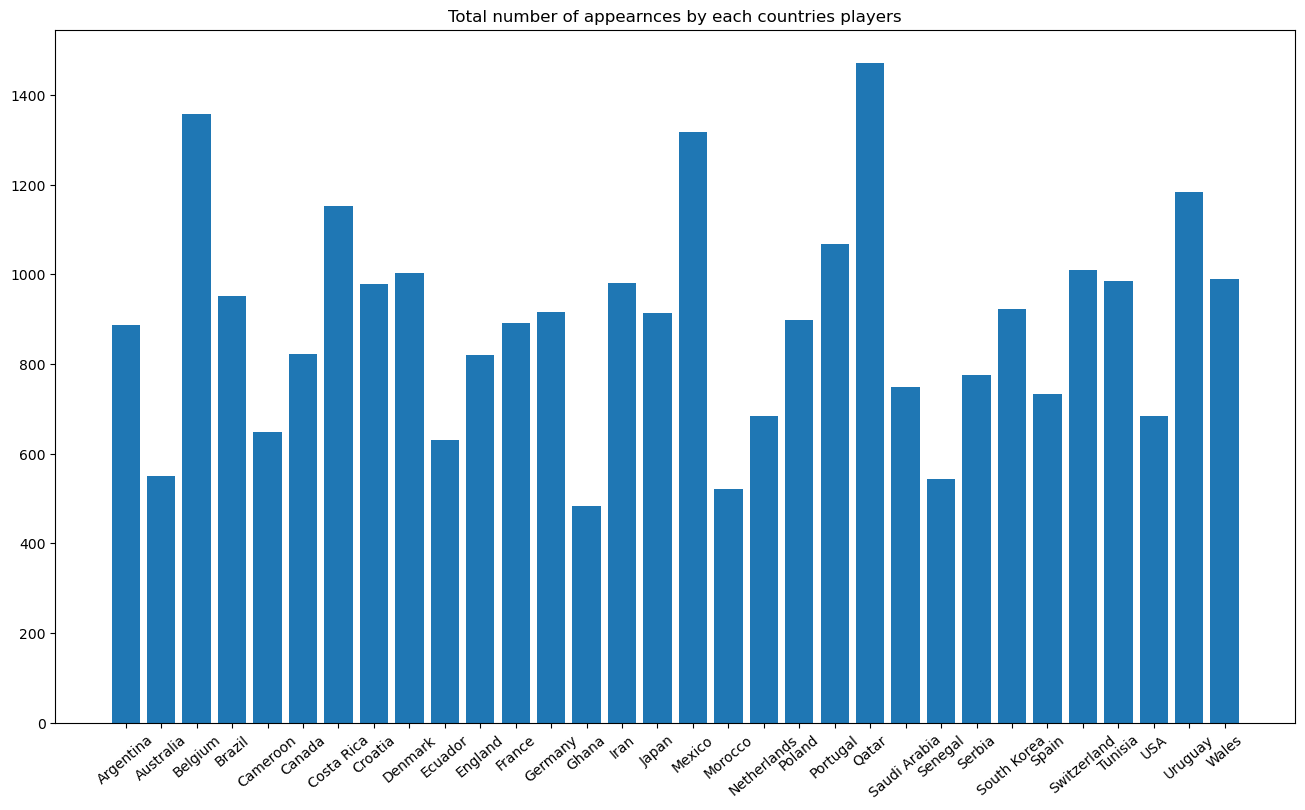

In [18]:
goals_by_country = df1.groupby('Country')['Goals'].sum()
caps_by_country = df1.groupby('Country')['Caps'].sum()


plt.figure(figsize=(16,9))
plt.bar(goals_by_country.index,goals_by_country.values)
plt.title("Total number of goals by each countries players")
plt.xticks(rotation=40)

plt.figure(figsize=(16,9))
plt.bar(caps_by_country.index,caps_by_country.values)
plt.title("Total number of appearnces by each countries players")
plt.xticks(rotation=40)



plt.show()

# Network part

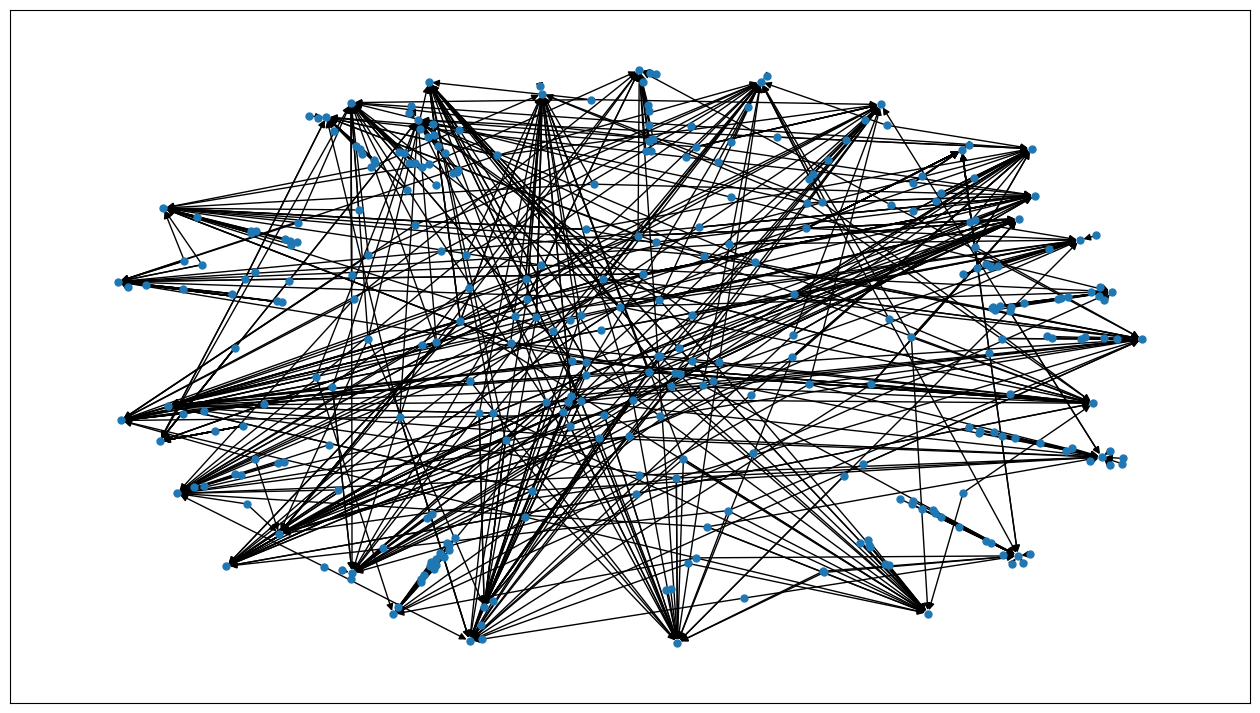

In [19]:
G = nx.from_pandas_edgelist(df1, source = 'Club', target = 'Country', create_using=nx.MultiDiGraph)

plt.figure(figsize = (16,9))
#layout = nx.spring_layout(g,iterations=50)
nx.draw_networkx(G,node_size =25,font_size =6, with_labels =False )
plt.show()

In [20]:
print(nx.info(G))

MultiDiGraph with 322 nodes and 830 edges


In [21]:
club = df1['Club']

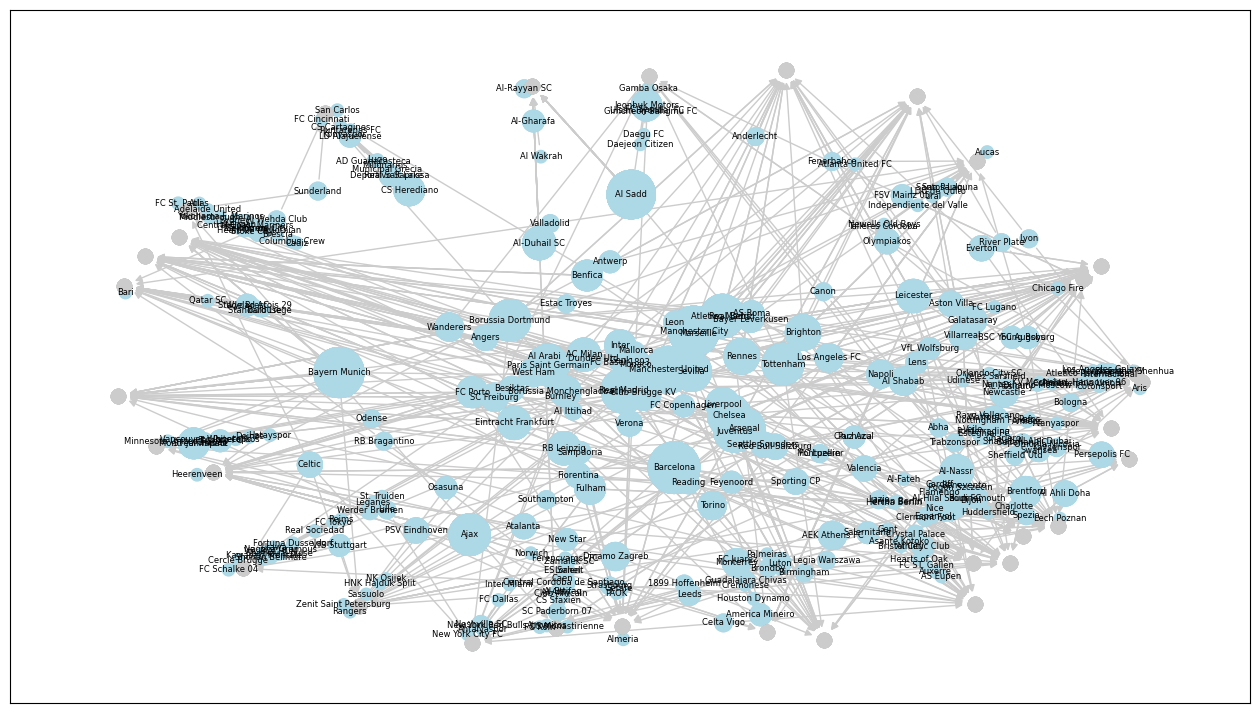

In [22]:
layout = nx.spring_layout(G,iterations=50)


plt.figure(figsize = (16,9))

club_size = [G.degree(club) * 80 for club in club]
nx.draw_networkx_nodes(G, 
                       layout, 
                       nodelist=club, 
                       node_size=club_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw EVERYONE
nx.draw_networkx_nodes(G, layout, nodelist=df1['Country'], node_color='#cccccc', node_size=100)

nx.draw_networkx_edges(G, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(club, club))
nx.draw_networkx_labels(G, layout, labels=node_labels, font_size=6 )

plt.show()

In [23]:
in_degree = G.in_degree()
sorted_in_degree = sorted(in_degree, key=lambda x: x[1], reverse=True)
print(sorted_in_degree[:10])

[('Ecuador', 26), ('Netherlands', 26), ('Argentina', 26), ('USA', 26), ('Wales', 26), ('Belgium', 26), ('Japan', 26), ('Spain', 26), ('Ghana', 26), ('Poland', 26)]


In [24]:
out_degree = G.out_degree()
sorted_out_degree = sorted(out_degree, key=lambda x: x[1], reverse=True)
print(sorted_out_degree[:10])

[('Barcelona', 17), ('Bayern Munich', 16), ('Manchester City', 16), ('Al Sadd', 15), ('Manchester United', 14), ('Real Madrid', 13), ('Al-Hilal Saudi FC', 12), ('Atletico Madrid', 12), ('Chelsea', 12), ('Ajax', 11)]


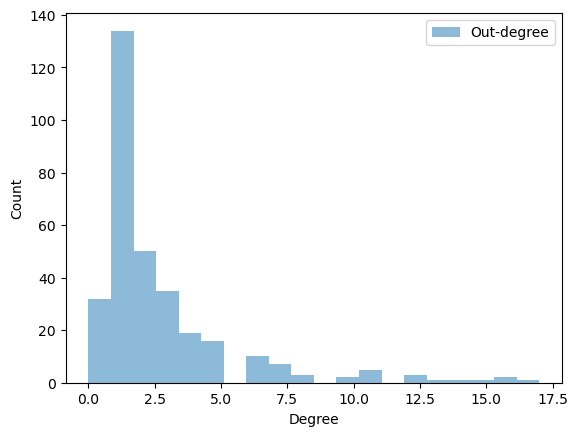

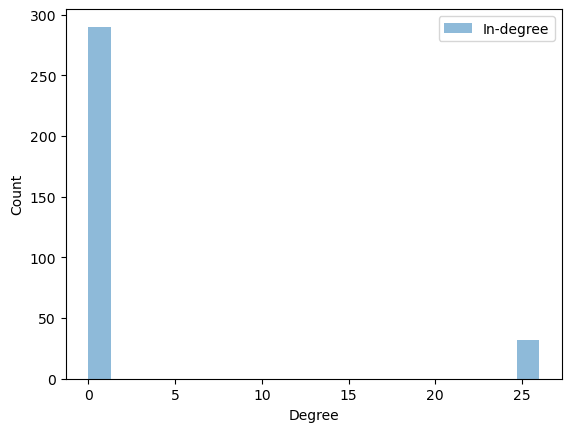

In [25]:
network_in_degrees = [G.in_degree(n) for n in G.nodes()]
network_out_degrees = [G.out_degree(n) for n in G.nodes()]

plt.hist(network_out_degrees, bins=20, alpha=0.5, label='Out-degree')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

plt.hist(network_in_degrees, bins=20, alpha=0.5, label='In-degree')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()


100%|██████████| 1000/1000 [00:01<00:00, 741.86it/s]


BarnesHut Approximation  took  0.41  seconds
Repulsion forces  took  0.77  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


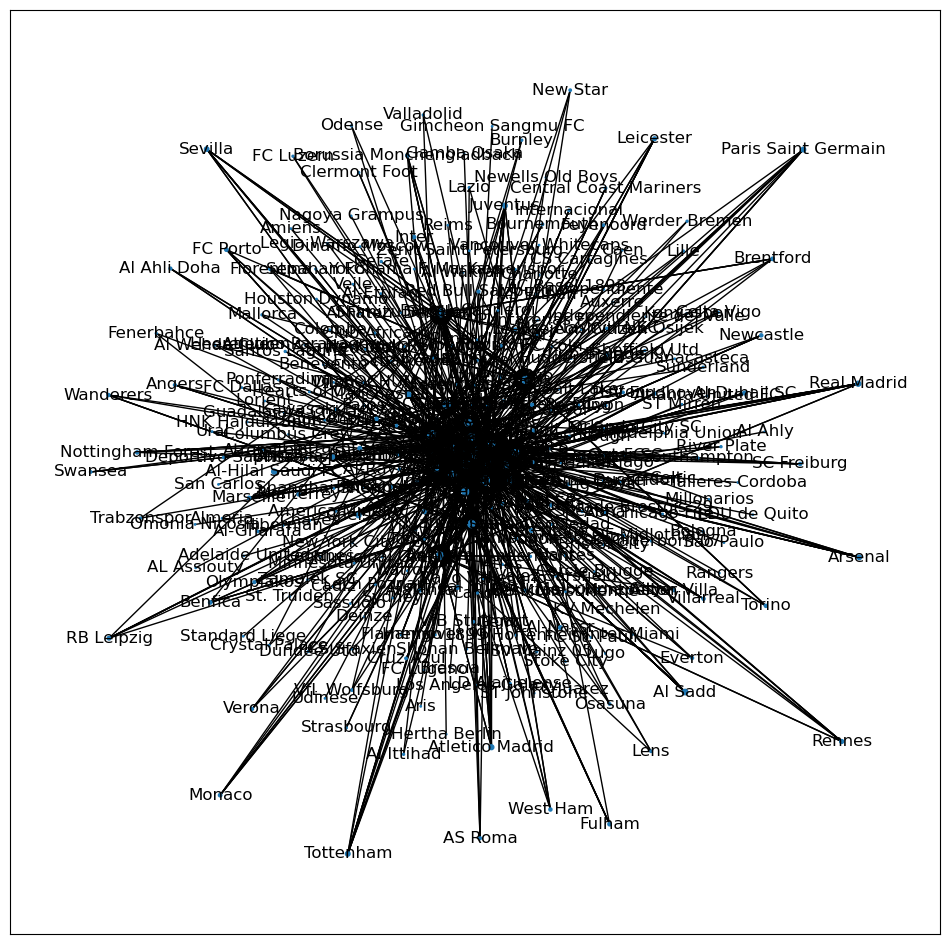

In [26]:
from fa2 import ForceAtlas2

node_size = [G.degree(i) * 1 for i in G.nodes()] 

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=positions,  with_labels=True, node_size=node_size)
plt.show()


# Downloadding wikilinks

In [27]:
# df1 Country to lower case
df1['Country'] = df1['Country'].str.lower()
df1

index Pos.            Player  Caps  Goals      Country  \
0        0   GK   Hernán Galíndez    12      0      ecuador   
1        1   DF      Félix Torres    17      2      ecuador   
2        2   MF   Ayrton Preciado    27      3      ecuador   
3        3   DF    Piero Hincapié    21      1      ecuador   
4        4   DF  Jeremie Frimpong     0      0  netherlands   
..     ...  ...               ...   ...    ...          ...   
825    826   DF    Jesús Gallardo    78      1       mexico   
826    827   DF     Johan Vásquez     7      0       mexico   
827    828   FW       Alexis Vega    22      6       mexico   
828    829   FW  Roberto Alvarado    31      4       mexico   
829    830   MF    Héctor Herrera   102     10       mexico   

                   Club  team_id Leauge_country          WikiLink  
0                 Aucas     1156        Equador   Hernán_Galíndez  
1         Santos Laguna     2285         Mexico      Félix_Torres  
2         Santos Laguna     2285         Mexico   Ayrton_Preciado  
3      Bayer Leverkusen      168        Germany    Piero_Hincapié  
4      Bayer Leverkusen      168        Germany  Jeremie_Frimpong  
..                  ...      ...            ...               ...  
825           Monterrey     2282         Mexico    Jesús_Gallardo  
826           Cremonese      520          Italy     Johan_Vásquez  
827  Guadalajara Chivas     2278         Mexico       Alexis_Vega  
828  Guadalajara Chivas     2278         Mexico  Roberto_Alvarado  
829      Houston Dynamo     1600            USA    Héctor_Herrera  

[830 rows x 10 columns]

In [28]:
import requests

for i in range(len(df1)):

    
 if i == 772: # skip cho-yu-min
    continue
 else:
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + df1['WikiLink'][i]
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    #print(query)
    wikiresponse = requests.get(query)
    wikidata = wikiresponse.text
    wikitext = wikidata
    #wikitext = wikidata.decode('utf-8')

    #save the wikitext in a file

    with open(df1['WikiLink'][i]+'_player_'+df1['Country'][i]+'.txt', 'w') as f:
        f.write(wikitext)


In [29]:
def parse_links_from_file(file):
    links = set()
    for link in re.findall('\[\[([^\]]*)\]\]', file):
        if '|' in link:
            link = link.split('|')[0]
        links.add(link)
    return [link.lower() for link in links]


def parse_node(node):
    # remove _player_ and everything after it in the filename
    return node.split("_player")[0].replace("_", " ").lower()


G1 = nx.DiGraph()
        
for i in os.listdir():
    if i.endswith(".txt"):
        with open(i, 'r') as f:
            file = f.read()
            G1.add_node(parse_node(i), file=i, words = len(re.findall(r'\w+', file)))
         
        
        
        
#add edges to the network
edges = {}

for i in G1.nodes(data=True):
    with open(i[1]['file'], 'r') as f:
        file = f.read()
        links = parse_links_from_file(file)
        edges[i[0]] = links

for name, edges in edges.items():
    for edge in edges:
        if edge in list(G1.nodes):
            G1.add_edge(*(name, edge))


In [30]:
print(nx.info(G1))

DiGraph with 829 nodes and 806 edges


In [31]:
G2 = max(nx.weakly_connected_components(G1), key=len)

G2 = G1.subgraph(G2)

In [32]:
print(nx.info(G2))

DiGraph with 363 nodes and 776 edges


In [33]:
print(nx.info(G2))
print("In-degrees",pd.Series([x[1] for x in list(G2.in_degree)]).describe())
print("Out-degrees:",pd.Series([x[1] for x in list(G2.out_degree)]).describe())

DiGraph with 363 nodes and 776 edges
In-degrees count    363.000000
mean       2.137741
std        4.538696
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       51.000000
dtype: float64
Out-degrees: count    363.000000
mean       2.137741
std        2.236755
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       12.000000
dtype: float64


In [34]:
labeling={}

for i in G2.nodes:
    if G2.degree()[i] > 20:
        labeling[i] = i
        


100%|██████████| 100/100 [00:00<00:00, 689.12it/s]


BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.09  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


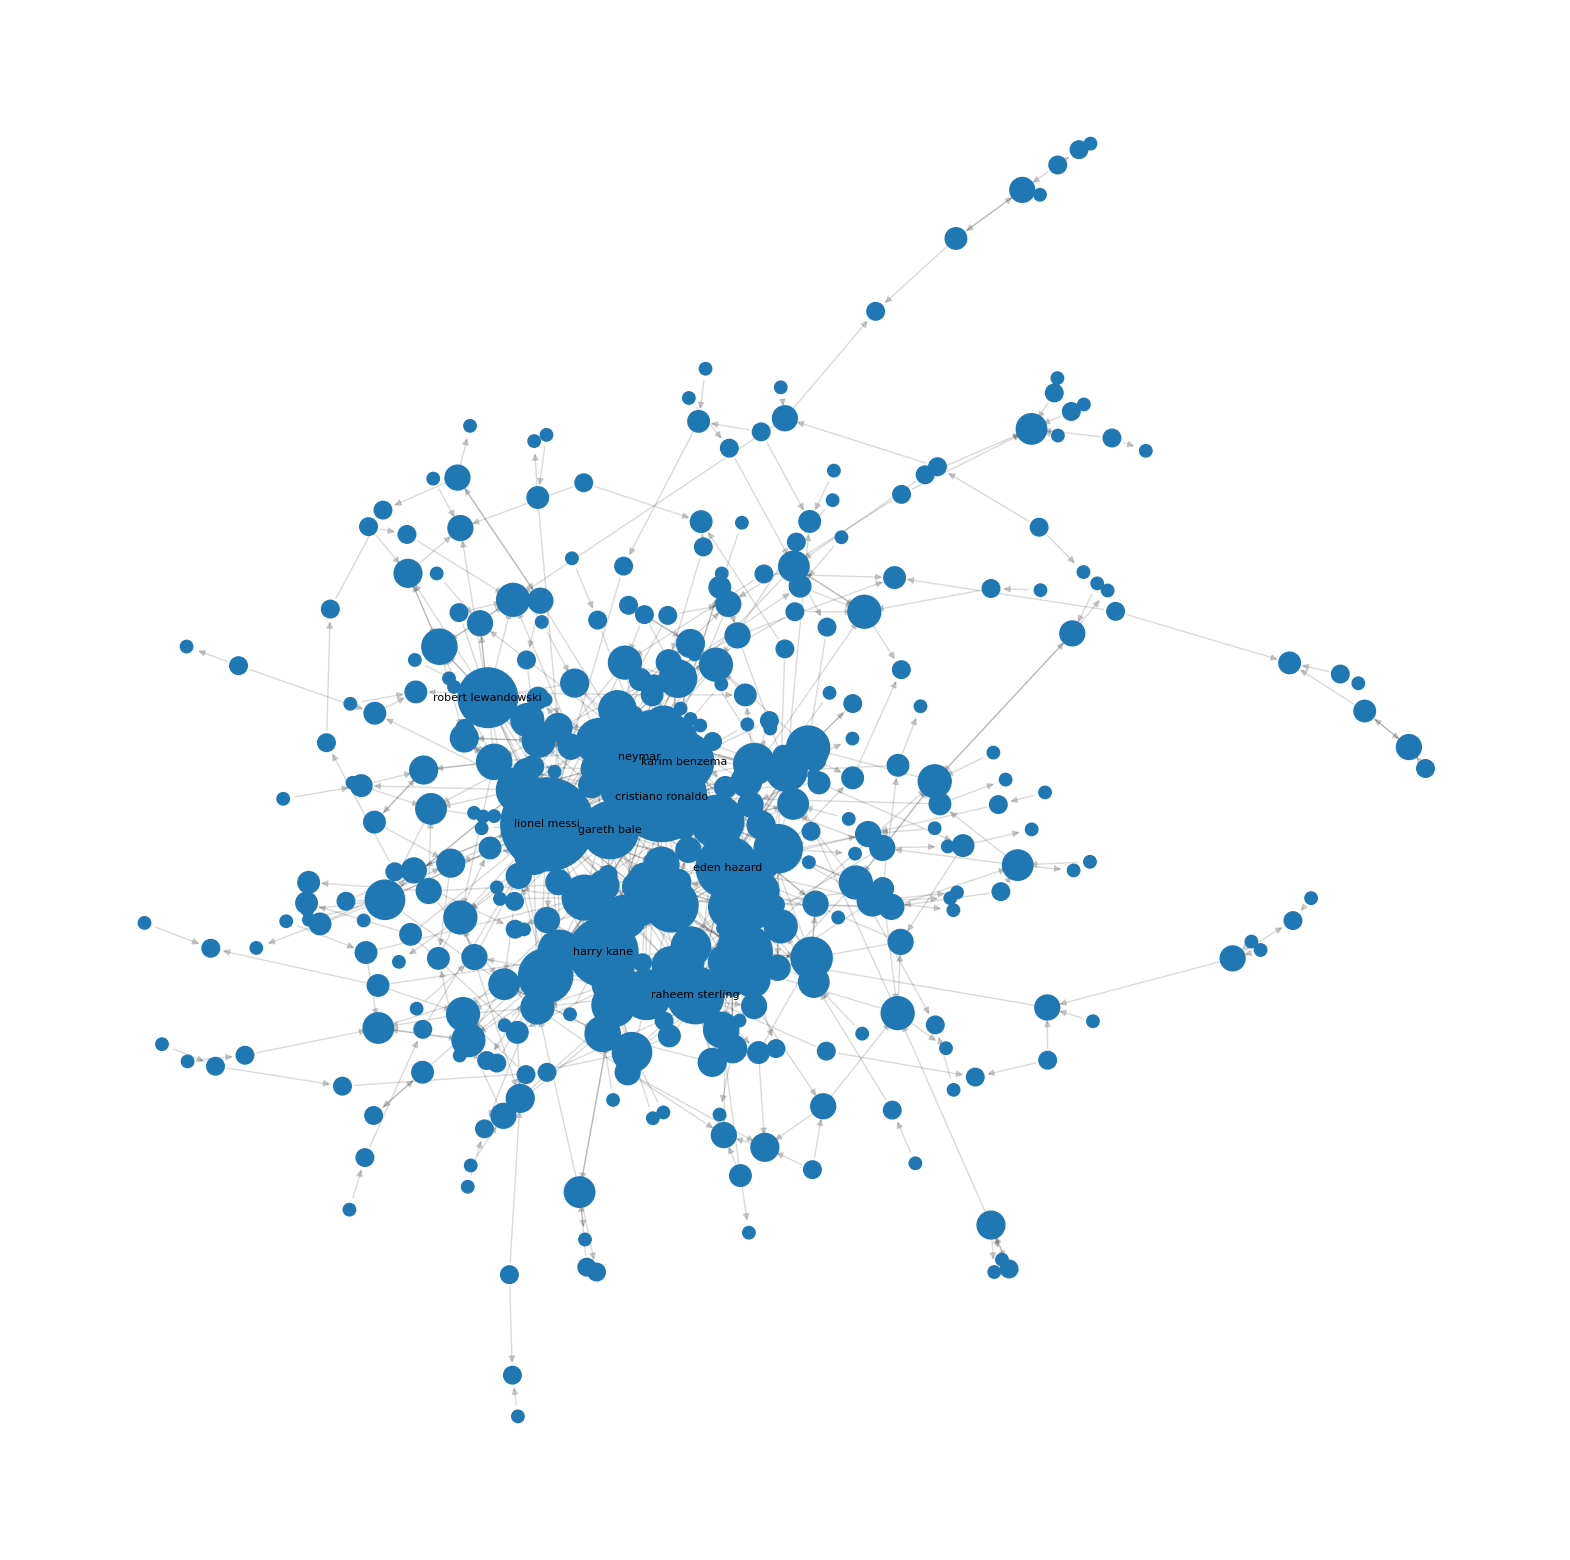

In [35]:
forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.5,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

node_size = [G2.degree(i) * 80 for i in G2.nodes()] 
positions = forceatlas2.forceatlas2_networkx_layout(G2.to_undirected() , pos=None, iterations=100)

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G2, positions, node_size = node_size) #, alpha=0.5) 
nx.draw_networkx_edges(G2, positions, alpha=0.15)
nx.draw_networkx_labels(G2, positions, labels = labeling, font_size = 8)
plt.axis('off')
plt.show()


In [36]:
def getColorList(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G2.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#4495b3") # blue
    return colorList


def getLabeling(sortedList, topN):
    labeling={}
    for node in G2.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling


def plot(sizes,colors, labeling, adjustFactor): # adjustFactor to control node size
    plt.figure(figsize=(15,10))
    nx.draw_networkx_edges(G2, positions, width = 0.1, alpha = 0.8, arrows=False)
    nx.draw_networkx_nodes(G2, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G2, positions, labels=labeling, font_size=8)
    plt.show()
    return 


In [37]:
sorting=sorted(list(G2.in_degree()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3


[('lionel messi', 51), ('cristiano ronaldo', 44), ('neymar', 20)]

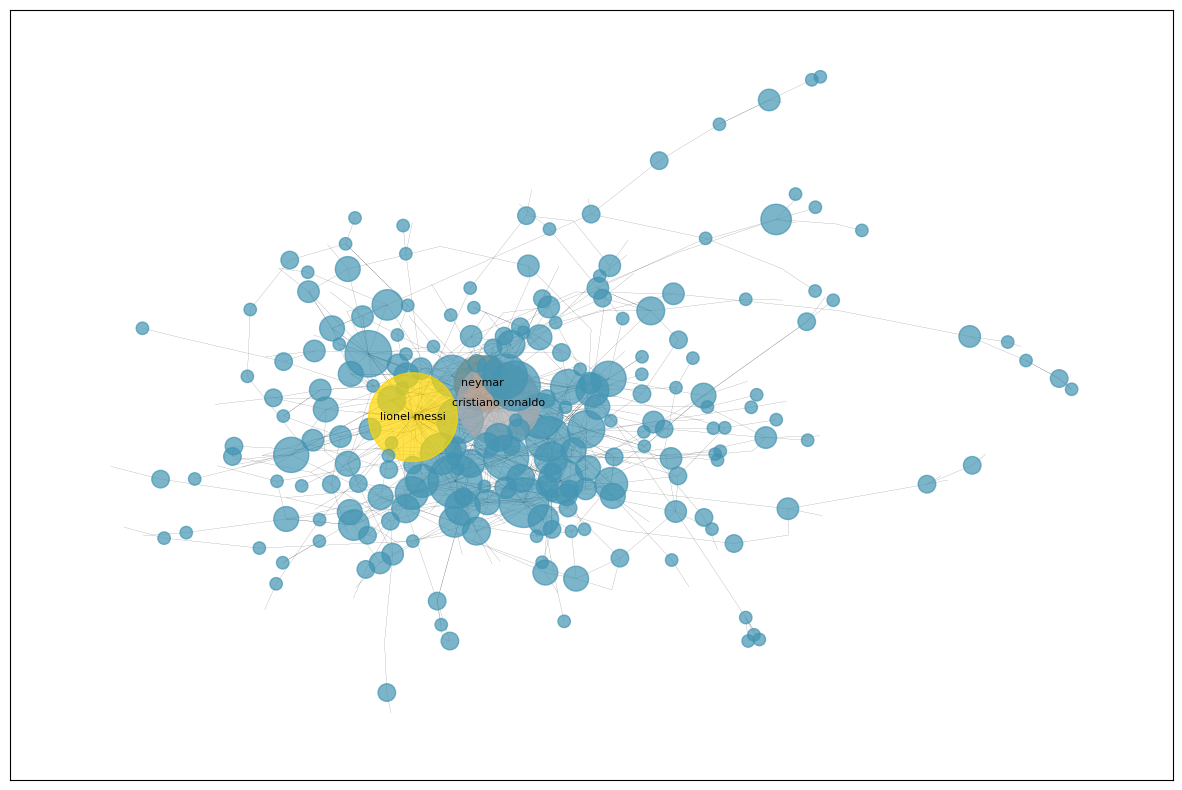

In [38]:

plot([G2.in_degree(i) for i in G2.nodes],
     getColorList('lionel messi','cristiano ronaldo','neymar'),getLabeling(sorting,3),80 )


In [39]:

sorting=sorted(list(nx.closeness_centrality(G2).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3


[('lionel messi', 0.301898349118653),
 ('cristiano ronaldo', 0.30144976316156735),
 ('neymar', 0.2577835967061433)]

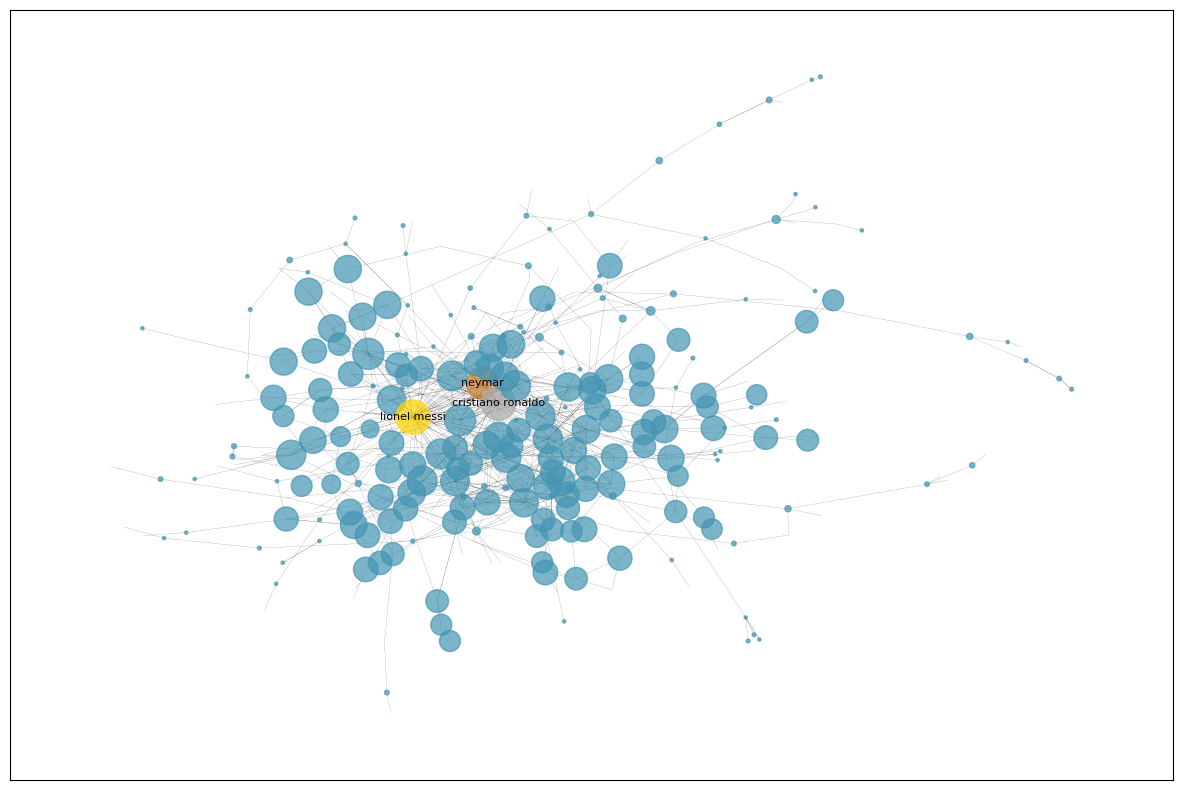

In [40]:
plot(list(nx.closeness_centrality(G2).values()),
     getColorList('lionel messi','cristiano ronaldo','neymar'),
     getLabeling(sorting, 3), 2000)

# Community 

In [41]:

def getLabeling(sortedList, topN):
    labeling={}
    for node in G.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling


In [42]:
G = nx.Graph()
G.add_nodes_from(df1['Player'])
G.add_edges_from([(df1['Player'][i], df1['Country'][i]) for i in range(len(df1))])
G.add_edges_from([(df1['Player'][i], df1['Club'][i]) for i in range(len(df1))])
G.add_edges_from([(df1['Player'][i], df1['Leauge_country'][i]) for i in range(len(df1))])

partition = community_louvain.best_partition(G)

In [43]:
sorting=sorted(list(G.degree()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('England', 155), ('Spain', 88), ('Germany', 82)]

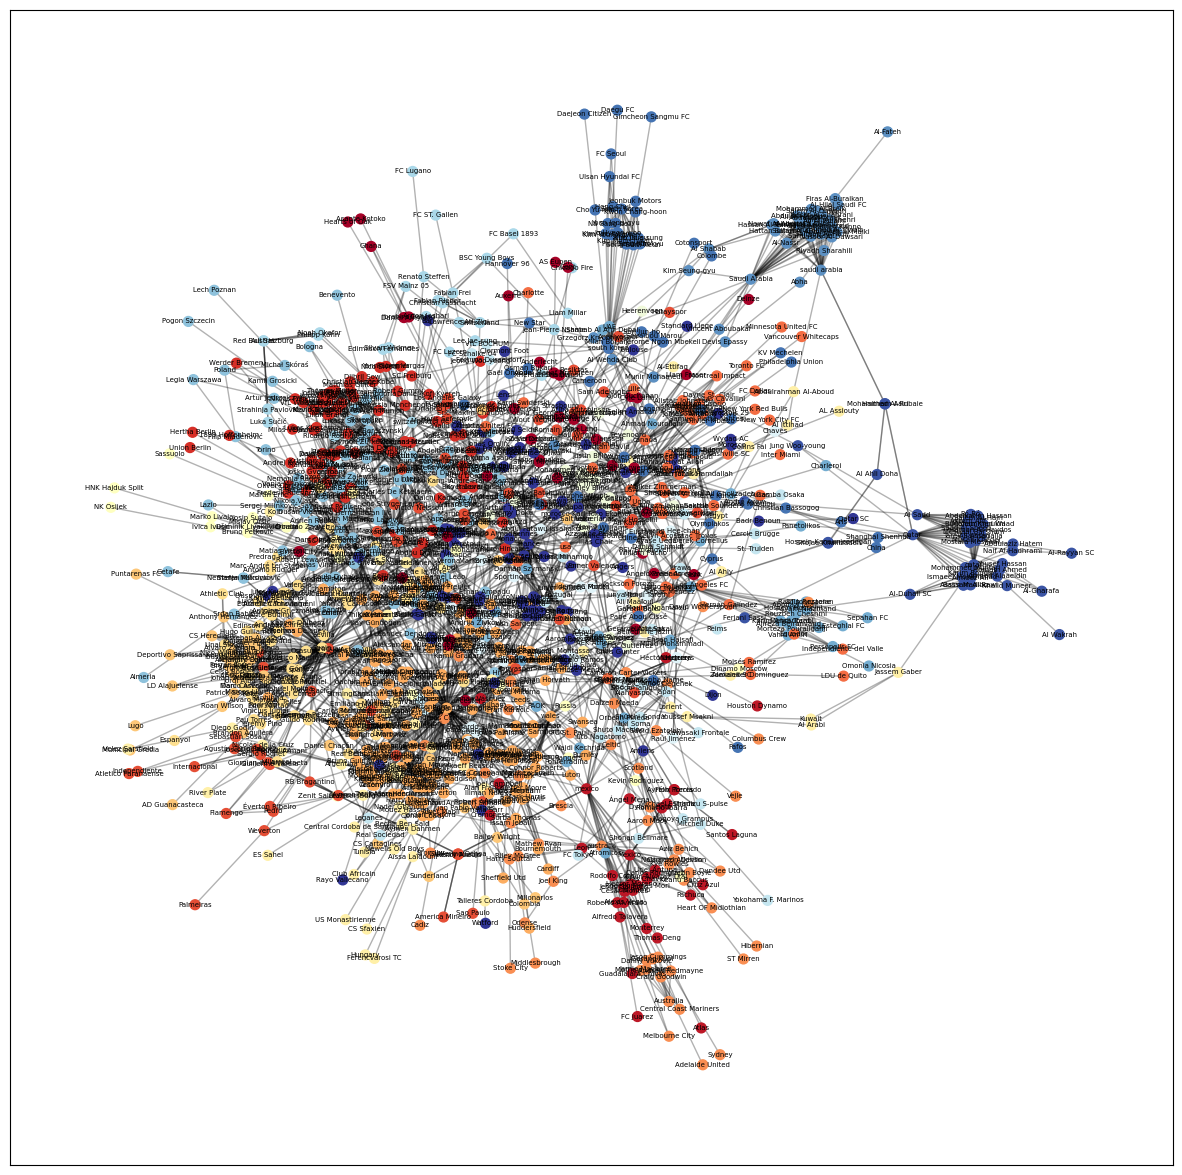

In [44]:
pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3, label =getLabeling(sorting, 3))
nx.draw_networkx_labels(G, pos,font_size=5)

plt.show()

In [45]:
print("This is my minimum",min(partition.values()))
print("This is my minimum",max(partition.values()))

This is my minimum 0
This is my minimum 20


# Sentiment part

In [46]:
all_ids = {
        "equador": "1xc85Qk0pzoeR5jpeLU1dP9HddFqdjVty-Kv4tjC8XPY",
        "netherlands": "1N1wf1oUw8OwLj1kXbixifY0xD1tW9RW17r8l3veG86g",
        "qatar": "1lMvk1bSJ24SPd8I5eMjMXBVr6OO-bKkw_J0NjPZt2nA",
        "seneegal": "1V6SD0MqUVs3J0EhHaPHiNRZkyDEqGnGVWJnex-QW_hE",
        "england": "15retV7YllqsTR_MyW8nOgUf9fVm3TroJRVtkGHFBqrw",
        "iran": "17HY03KVeq0WQCNl0SnehJa18FK2b7QPNzpvfUpTNbpU",
        "united-states": "1147Na6XK5N-GvstVHDtt4eGhJVuw2HSvGUtqEjjhPbs",
        "wales": "1pbgL-f7fyh8iI0OGibqeR6W6xYO2LtA4xPjIHEkEpeo",
        "argentina": "1JABE3VYTo1F0t9WxcGsDjC6a2idF8d_btbtIIgwV1FU",
        "mexico": "1cmn2MO_NnsvhkYtbDqQ-WTWu51fYzxAChHujEKpjI24",
        "polen": "1cWW9DraYiyf7A5ueITLAQIcXgn8WjI7vK3TolIvwfQQ",
        "australien": "1gdXa2jAl_TDsNUbc3KcXmJmFN5jY3YxUcpXS9XrgjJI",
        "denmark": "1mz3egryRXHuIEppc7WNTHAg89I53_zkCIQ2oKqn4zWA",
        "france": "1m-rwGKnlDbEItNFKcf6daNG63ib5verOatxm6XK3a0A",
        "tunesien": "1zxHZ7SPEUnPqb9xbV4NSfSTCQxUnfDq9gSF9nO-0d7w",
        "costa-rica": "1obbrY1o71q5hcWGBCicg9xSGUv5lCfT-c14DqLxsiYU",
        "germany": "1cdWojP9yF0BFQxN47d4PfokRP7K8n46fUhZ4JYh3FAA",
        "japan": "1yjeG9H28FZJag88-CRsbjuQxYHPR1gpm-OsfwFZdhsw",
        "spain": "1Xv6kMCgho1Yr9a3f4JZoDWcn4MGi3jNtwq_LSwhmPoE",
        "belgium": "1tHvzmC0Pz2z_CT_F91Jh4dSnGXo_VE8FEyKkgTXkti8",
        "canada": "142exB4McAfVXgX26jhpErMr1K0yJe-iZioYa1Wro0So",
        "croatia": "1bLItGv7x-JqN2-L2RWqags1mrIHI0N-qiN8mx0nS24E",
        "morocco": "1hANEXs8eTKHtMSxpjDLygD6F-UEwWXoEtLG6oU6ollo",
        "brazil": "173Xiho8VrXMDbOMVapH33L1w044kA1bbUBnd8oltcys",
        "cameroon": "1L88yR6tadKyhz_4jeZu5-myBHSLT-TDqu6odB4TNrFk",
        "serbia": "13O5oZpcZnhD7BKWy-JlE3oBKqBV0N2h46_lIYEDjcbU",
        "switzerland": "1b1q3vgoZjYSLFZtBZg2N0PnJJGn2E7_C0HvaFugJYDg",
        "ghana": "1WtYFKbyuOfwn2mfCYFZSr7-f8UKuv3ooDFRWDcbd1P4",
        "portugal": "1Qys1bSclmV04XYCAbTqPJuxQ13HeluyxhjIVp3g8Izo",
        "south korea": "1kEvxOJL5iv9cEQPGAZJ4B7NqyYLd1yT1l6_aI2ItX5o",
        "uruguay": "1-SNLlwhppsF9IYdfUDnWpBNGywGl2LEKgAnS1X6pZSc",
}
 
def get_team_info(id):
    headers = {
        'authority': 'interactive.guim.co.uk',
        'origin': 'https://www.theguardian.com',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    }
    
    response = requests.get(f'https://interactive.guim.co.uk/docsdata/{id}.json', headers=headers)
    data1 = response.json()
    return data1
 
def get_team_summaries():
    response = requests.get('https://www.theguardian.com/football/ng-interactive/2022/nov/16/world-cup-2022-player-profiles-qatar-match-ratings')
    test = response.content
    soup = BeautifulSoup(test, 'html.parser')
    data2 = {}
    data2['gv-team-info-bio'] = soup.find_all('p', class_='gv-team-info-bio')
    data2['gv-team-info-strengths'] = soup.find_all('p', class_='gv-team-info-strengths')
    data2['gv-team-info-weaknesses'] = soup.find_all('p', class_='gv-team-info-weaknesses')
    data2['gv-team-info-coach'] = soup.find_all('div', class_='gv-team-info-coach')
    return data2
 
team_summaries = get_team_summaries()
 

for i, name in enumerate(all_ids.keys()):
    team_summary = [get_team_info(all_ids[name])]
    team_summary.append(team_summaries['gv-team-info-bio'][i].text)
    team_summary.append(team_summaries['gv-team-info-strengths'][i].text)
    team_summary.append(team_summaries['gv-team-info-weaknesses'][i].text)
    team_summary.append(team_summaries['gv-team-info-coach'][i].text)
    # save a text file with teaminfo and team_summary called name.txt
    with open(f'{name}_guardian.txt', 'w', encoding='utf-8') as f:
        f.write(str(team_summary))

In [57]:
senti_set = pd.read_csv("Data_Set_S1.txt", sep="\t")

In [49]:
#senti_set = senti_set.drop(columns =['happiness_rank','twitter_rank','twitter_rank','google_rank','nyt_rank','lyrics_rank'])

#removing delta 2 around average 5.
senti_set = senti_set.drop(senti_set[(senti_set['happiness_average'] <= 6) & (senti_set['happiness_average'] >= 4)].index)
senti_set.reset_index(drop = True, inplace=True)

word_happiness = dict(zip(senti_set.word.tolist(), senti_set.happiness_average.tolist())) # creating a dict that matches word with happiness

In [50]:
stop_words = nltk.corpus.stopwords.words('english') # removing stopwords

def prep_text(x): # preparing the data, removing what is not needed 
    corp = str(x).lower() 
    corp = re.sub('[^a-zA-Z]+',' ', corp).strip() 
    tokens = word_tokenize(corp)
    words = [t for t in tokens if t not in stop_words]

    return words


def sentiment(tokens): # here we are couniting the tokens 
    total=0
    count=0
    for t in tokens:
        # if Token found in the text
        if t in word_happiness:
            total += word_happiness[t]
            count +=1
    # If tokens are not in the list then it is set to 0(being ignored) 
    if count == 0:
        return 0
    return total/count

### The guardian article

In [58]:
senti_score_guardian = []

for i,country in enumerate(all_ids.keys()):
    for i in os.listdir():
        if i.startswith(f'{country}_guardian.txt'):
            with open(i,'r', encoding = 'utf-8') as f:
                senti_score_guardian.append(sentiment(prep_text(f.read())))
                #print(f'The sentiment score for {all_ids[i]} is {senti_score_guardian[country]}')

In [60]:
for i,country in enumerate(all_ids.keys()):
    print(f'{country}: {senti_score_guardian[i]}')

equador: 6.502355507088343
netherlands: 6.28535469107551
qatar: 6.487093333333327
seneegal: 6.388806451612912
england: 6.457486136783741
iran: 6.335091164095372
united-states: 6.531232394366195
wales: 6.419323915237129
argentina: 6.325565843621401
mexico: 6.309128686327077
polen: 6.445859788359787
australien: 6.346546583850932
denmark: 6.358838862559242
france: 6.256355140186915
tunesien: 6.33141534391534
costa-rica: 6.395147219193024
germany: 6.416725663716815
japan: 6.495985611510794
spain: 6.354600938967134
belgium: 6.396678529062867
canada: 6.49341115434501
croatia: 6.376732429099878
morocco: 6.3199999999999985
brazil: 6.376450999048536
cameroon: 6.418419889502762
serbia: 6.349052890528905
switzerland: 6.341203407880734
ghana: 6.39923076923077
portugal: 6.440070754716987
south korea: 6.4564766248574745
uruguay: 6.4186159600997525


In [61]:

# happiest

positive_countries = sorted(zip(all_ids.keys(),senti_score_guardian), key = lambda x: x[1], reverse = True)[:10]

print('The guardians top 10 favorit squads')
for i in positive_countries:
    print(i[0])
    
    
# saddest

negativ_countries = sorted(zip(all_ids.keys(),senti_score_guardian), key = lambda x: x[1])[:10]

print('The guardians top 10 least favorit squads')
for i in negativ_countries:
    print(i[0])

The guardians top 10 favorit squads
united-states
equador
japan
canada
qatar
england
south korea
polen
portugal
wales
The guardians top 10 least favorit squads
france
netherlands
mexico
morocco
argentina
tunesien
iran
switzerland
australien
serbia


### wordcloud

In [62]:
def term_f(token_list):
    
    tf={}
    
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
            
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    
    return tf



# Fifa articles 

In [63]:
ids = pd.read_csv("Article_fifa_ids.csv", delimiter=";")

In [64]:
for i in range(len(ids)):



    article_ID = ids['Artikel_id'][i]

    response = requests.get(

    f'https://cxm-api.fifa.com/fifaplusweb/api/sections/article/{article_ID}'

    )

    data = response.json()



    title = response.json()['articleTitle']

    text = response.json()['richtext']['content']



    #save the wikitext in a file



    with open(ids['land'][i] + '_FIFA.txt', 'w', encoding="utf-8") as f:

        f.write(str(text))

In [65]:
senti_score_fifa = []

for i in os.listdir():
    if i.endswith('_FIFA.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_fifa.append(sentiment(prep_text(f.read())))

In [66]:
# happiest

positive_countries = sorted(zip(all_ids.keys(),senti_score_fifa), key = lambda x: x[1], reverse = True)[:10]

print('FIFAs top 10 favorit squads')
for i in positive_countries:
    print(i[0])
    
    
# saddest

negativ_countries = sorted(zip(all_ids.keys(),senti_score_fifa), key = lambda x: x[1])[:10]

print('FIFAs top 10 least favorit squads')
for i in negativ_countries:
    print(i[0])

FIFAs top 10 favorit squads
polen
england
serbia
australien
argentina
germany
qatar
japan
iran
mexico
FIFAs top 10 least favorit squads
belgium
france
equador
portugal
spain
united-states
wales
cameroon
croatia
seneegal


#### Wordcloud

# Wiki articels 

In [67]:
# create a new dataframe with df1['Country] unique values

df2 = pd.DataFrame(df1['Country'].unique())

# rename the column

df2.columns = ['Country']

# replace " " with "_"

df2['Country'] = df2['Country'].str.replace(' ', '_').str.lower()

for i in range(len(df2)):



    #get the wikitext

    baseurl = "https://en.wikipedia.org/w/api.php?"

    action = "action=query"

    title = "titles=" + df2['Country'][i] + "_national_football_team"

    content = "prop=revisions&rvprop=content"

    dataformat ="format=json"

    

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    print(query)

    wikiresponse = requests.get(query)

    wikidata = wikiresponse.text

    wikitext = wikidata

    with open(df2['Country'][i] + '_wiki.txt', 'w') as f:

        f.write(wikitext)

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=ecuador_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=netherlands_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=iran_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=argentina_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=usa_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=wales_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=belgium_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=japan_national_footbal

In [68]:
senti_score_wiki = []

for i in os.listdir():
    if i.endswith('_wiki.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_wiki.append(sentiment(prep_text(f.read())))

In [69]:
# happiest

positive_countries_wiki = sorted(zip(all_ids.keys(),senti_score_wiki), key = lambda x: x[1], reverse = True)[:10]

print('Wikipedias top 10 favorit squads')
for i in positive_countries_wiki:
    print(i[0])
    
    
# saddest

negativ_countries_wiki = sorted(zip(all_ids.keys(),senti_score_wiki), key = lambda x: x[1])[:10]

print('Wikipedias top 10 least favorit squads')
for i in negativ_countries_wiki:
    print(i[0])

Wikipedias top 10 favorit squads
canada
denmark
south korea
seneegal
mexico
uruguay
tunesien
germany
equador
iran
Wikipedias top 10 least favorit squads
qatar
ghana
costa-rica
switzerland
belgium
argentina
australien
spain
cameroon
wales


In [70]:
# make df2 Country to lower case

df2['Country'] = df2['Country'].str.lower()
df2.head()

Country
0      ecuador
1  netherlands
2         iran
3    argentina
4          usa

In [71]:
# loop through all files in os.listdir() and if the file contain the country name then add it to a new txt file with the country name and the word "combined" 

for i in os.listdir():
    for j in df2['Country']:
        if j in i:
            with open(j + '_combined.txt', 'a', encoding = 'utf-8') as f:
                with open(i, 'r', encoding = 'utf-8') as f2:
                    f.write(f2.read())

                    

In [72]:
senti_score_combined = []

for i in os.listdir():
    if i.endswith('_combined.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_combined.append(sentiment(prep_text(f.read())))





In [73]:
# happiest

positive_countries_combined = sorted(zip(all_ids.keys(),senti_score_combined), key = lambda x: x[1], reverse = True)[:10]

print('Wikipedias top 10 favorit squads')
for i in positive_countries_combined:
    print(i[0])
    
    
# saddest

negativ_countries_combined = sorted(zip(all_ids.keys(),senti_score_combined), key = lambda x: x[1])[:10]

print('Wikipedias top 10 least favorit squads')
for i in negativ_countries_combined:
    print(i[0])

Wikipedias top 10 favorit squads
argentina
netherlands
denmark
canada
polen
belgium
croatia
equador
mexico
morocco
Wikipedias top 10 least favorit squads
tunesien
qatar
cameroon
south korea
iran
portugal
england
ghana
serbia
germany


# Team exploration

In [74]:
# create a network for each country calling them "G"Country""" where league_country is linked and "G1"Country""" where club is the only link linked

for i in df1['Country'].unique():
    globals()['G' + i] = nx.DiGraph()
    globals()['G1' + i] = nx.DiGraph()
    for index, row in df1.iterrows():
        if row['Country'] == i:
            globals()['G' + i].add_node(row['Player'], club=row['Club'], League_country=row['Leauge_country'], caps=row['Caps'])
            globals()['G1' + i].add_node(row['Player'], club=row['Club'], League_country=row['Leauge_country'], caps=row['Caps'])
            
    for player1 in globals()['G' + i].nodes(data=True):
        for player2 in globals()['G' + i].nodes(data=True):
            if player1[1]['club'] == player2[1]['club']:
                if player1[0] != player2[0]:
                    globals()['G' + i].add_edge(player1[0], player2[0])
            if player1[1]['League_country'] == player2[1]['League_country']:
                if player1[0] != player2[0]:
                    globals()['G' + i].add_edge(player1[0], player2[0])
                    
    for player1 in globals()['G1' + i].nodes(data=True):
        for player2 in globals()['G1' + i].nodes(data=True):
            if player1[1]['club'] == player2[1]['club']:
                if player1[0] != player2[0]:
                    globals()['G1' + i].add_edge(player1[0], player2[0])


In [75]:
# loop through the networks and find the network with most edges
for i in df1['Country'].unique():
    print(i)
    print(nx.info(globals()['G' + i]))
    print(nx.info(globals()['G1' + i]))
    print('')

    

ecuador
DiGraph with 26 nodes and 50 edges
DiGraph with 26 nodes and 14 edges

netherlands
DiGraph with 26 nodes and 156 edges
DiGraph with 26 nodes and 54 edges

iran
DiGraph with 25 nodes and 78 edges
DiGraph with 25 nodes and 26 edges

argentina
DiGraph with 26 nodes and 126 edges
DiGraph with 26 nodes and 20 edges

usa
DiGraph with 26 nodes and 134 edges
DiGraph with 26 nodes and 8 edges

wales
DiGraph with 26 nodes and 348 edges
DiGraph with 26 nodes and 20 edges

belgium
DiGraph with 26 nodes and 90 edges
DiGraph with 26 nodes and 18 edges

japan
DiGraph with 26 nodes and 110 edges
DiGraph with 26 nodes and 4 edges

spain
DiGraph with 26 nodes and 328 edges
DiGraph with 26 nodes and 72 edges

ghana
DiGraph with 26 nodes and 78 edges
DiGraph with 26 nodes and 2 edges

poland
DiGraph with 26 nodes and 106 edges
DiGraph with 26 nodes and 4 edges

switzerland
DiGraph with 26 nodes and 88 edges
DiGraph with 26 nodes and 8 edges

mexico
DiGraph with 26 nodes and 170 edges
DiGraph with 

100%|██████████| 100/100 [00:00<00:00, 17758.93it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


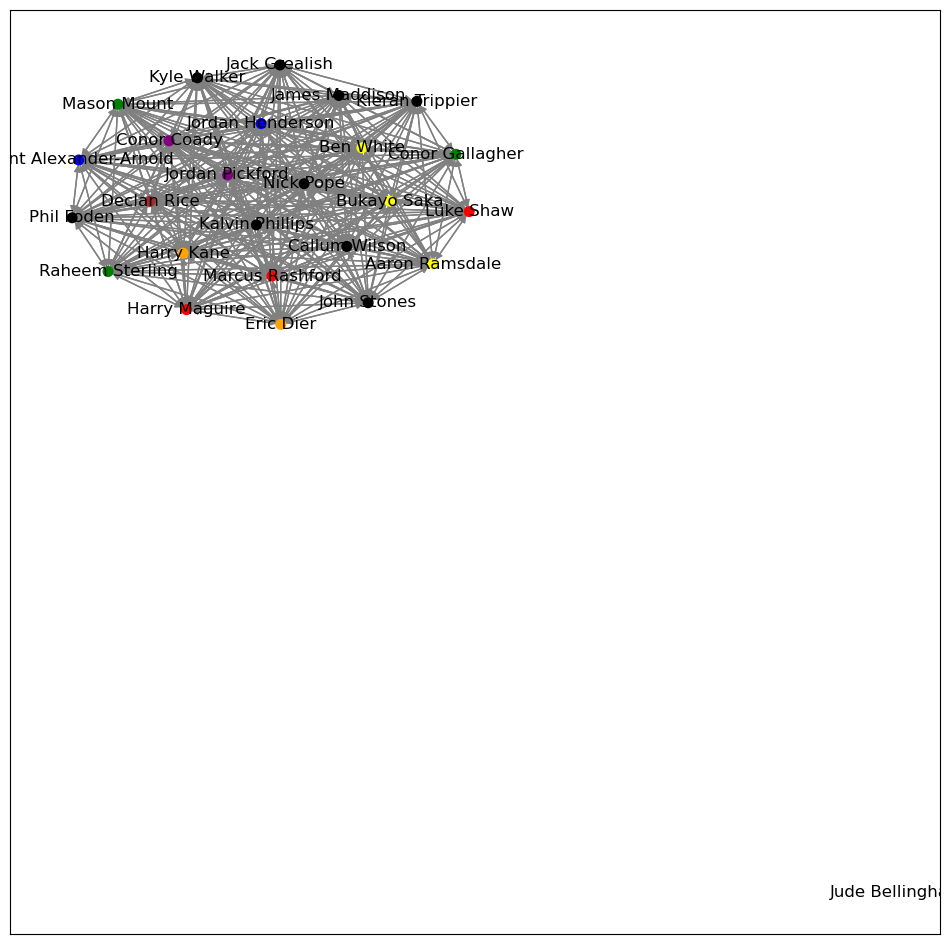

In [76]:
# draw the network for England
colormap = []
for i in Gengland.nodes(data=True):
    if i[1]['club'] == 'Manchester United':
        colormap.append('red')
    elif i[1]['club'] == 'Liverpool':
        colormap.append('blue')
    elif i[1]['club'] == 'Chelsea':
        colormap.append('green')
    elif i[1]['club'] == 'Arsenal':
        colormap.append('yellow')
    elif i[1]['club'] == 'Tottenham':
        colormap.append('orange')
    elif i[1]['club'] == 'Everton':
        colormap.append('purple')
    elif i[1]['club'] == 'Leicester':
        colormap.append('black')
    elif i[1]['club'] == 'West Ham':
        colormap.append('brown')
    elif i[1]['club'] == 'Aston Villa':
        colormap.append('pink')
    elif i[1]['club'] == 'Wolves':
        colormap.append('grey')
    else:
        colormap.append('black')

edge_color = []
for i in Gengland.edges(data=True):
    if i[0] == i[1]:
        edge_color.append('red')
    else:
        edge_color.append('grey')

node_size = [Gengland.degree(i) * 1 for i in Gengland.nodes()]

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=0.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(Gengland, pos=None, iterations=100)

plt.figure(figsize=(12,12))
nx.draw_networkx(Gengland, pos=positions, node_size=node_size, node_color=colormap, edge_color=edge_color, with_labels=True)
plt.show()




100%|██████████| 100/100 [00:00<00:00, 16832.43it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


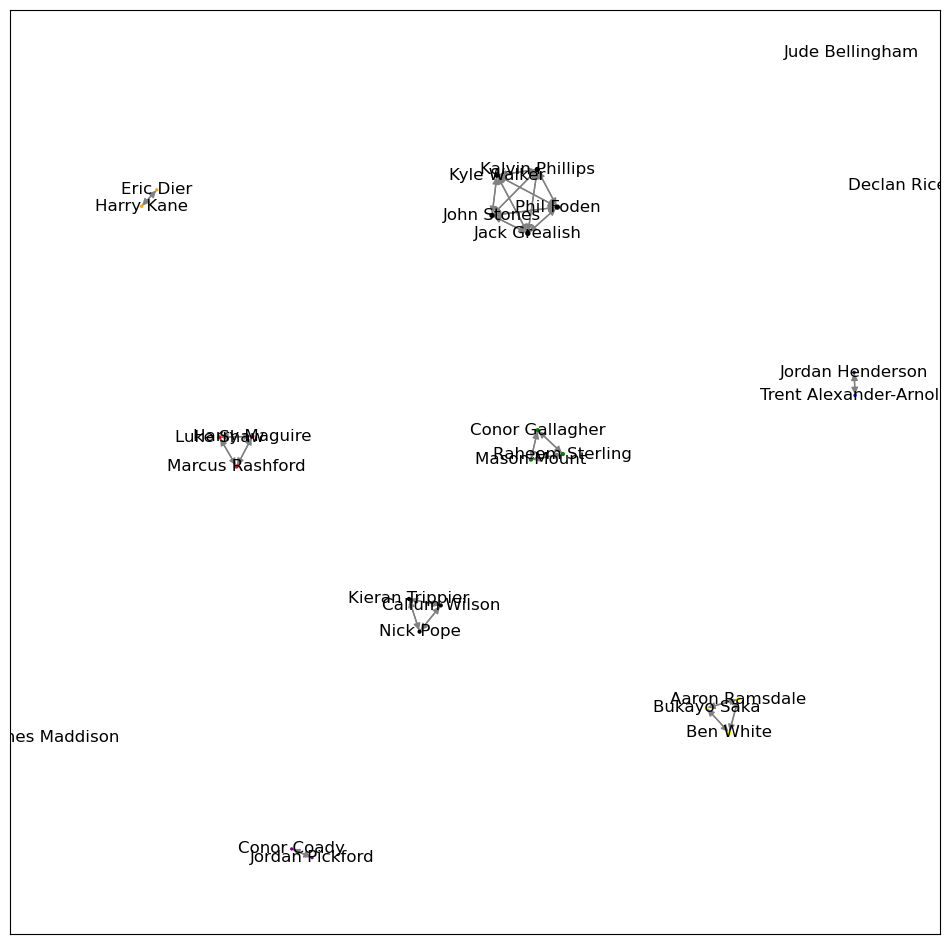

In [77]:
# draw the network for England
colormap = []
for i in G1england.nodes(data=True):
    if i[1]['club'] == 'Manchester United':
        colormap.append('red')
    elif i[1]['club'] == 'Liverpool':
        colormap.append('blue')
    elif i[1]['club'] == 'Chelsea':
        colormap.append('green')
    elif i[1]['club'] == 'Arsenal':
        colormap.append('yellow')
    elif i[1]['club'] == 'Tottenham':
        colormap.append('orange')
    elif i[1]['club'] == 'Everton':
        colormap.append('purple')
    elif i[1]['club'] == 'Leicester':
        colormap.append('black')
    elif i[1]['club'] == 'West Ham':
        colormap.append('brown')
    elif i[1]['club'] == 'Aston Villa':
        colormap.append('pink')
    elif i[1]['club'] == 'Wolves':
        colormap.append('grey')
    else:
        colormap.append('black')

edge_color = []
for i in G1england.edges(data=True):
    if i[0] == i[1]:
        edge_color.append('red')
    else:
        edge_color.append('grey')

node_size = [G1england.degree(i) * 1 for i in G1england.nodes()]

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=0.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G1england, pos=None, iterations=100)

plt.figure(figsize=(12,12))
nx.draw_networkx(G1england, pos=positions, node_size=node_size, node_color=colormap, edge_color=edge_color, with_labels=True)
plt.show()


All players except one player plays in the English league

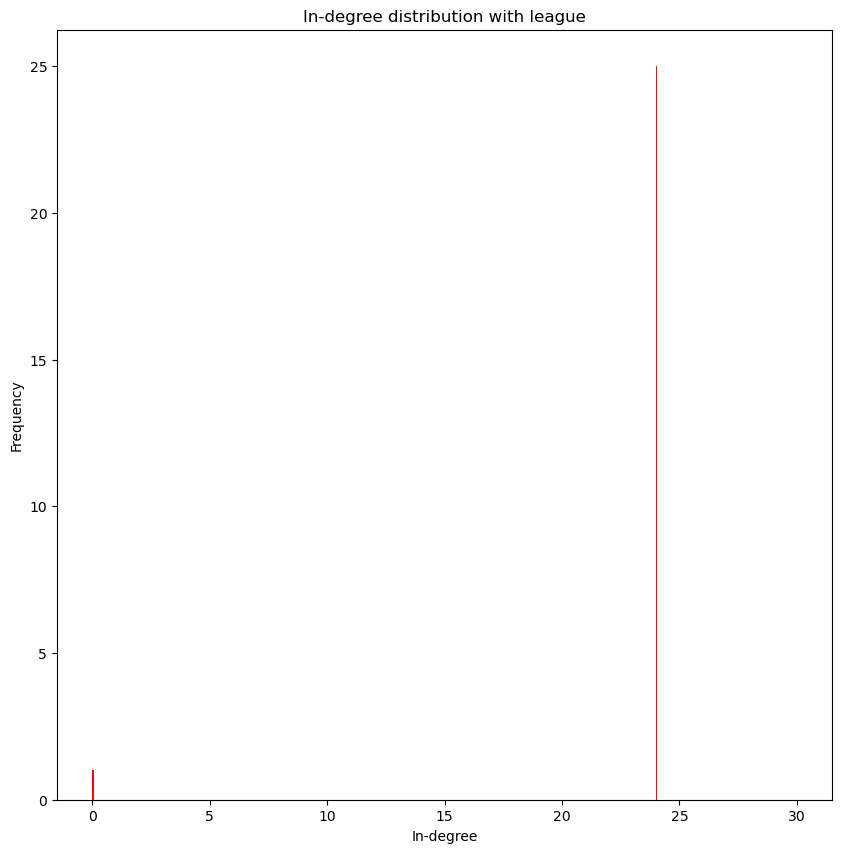

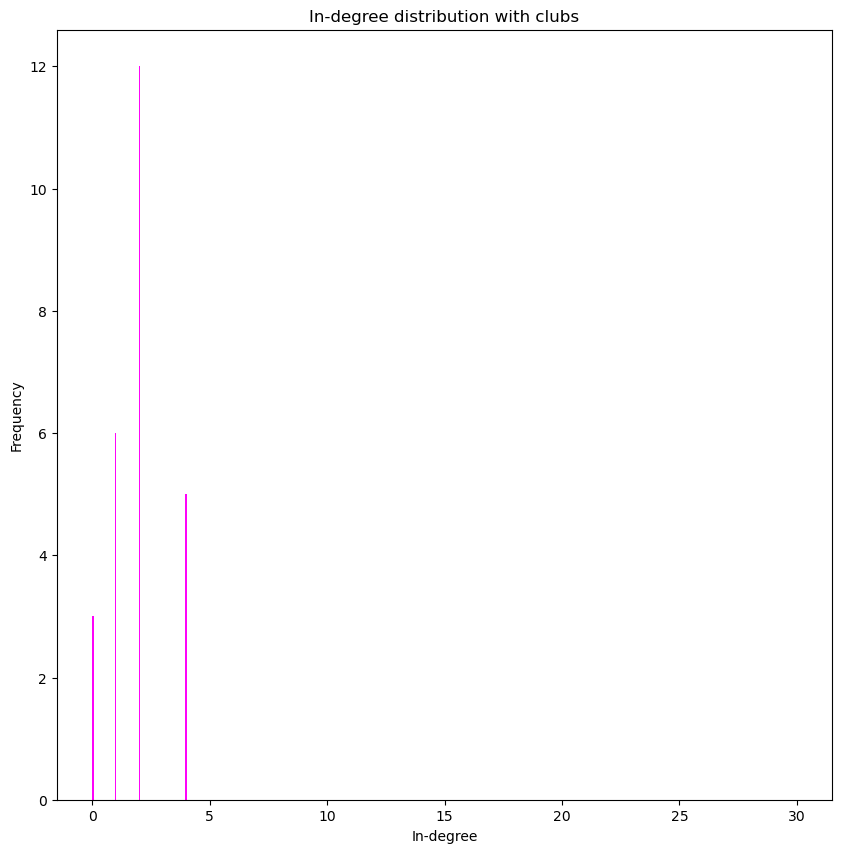

In [78]:
#create in-degree and out-degree distributions for the network

in_degree_with_league = list(dict(Gengland.in_degree()).values())
In_degree_with_clubs = list(dict(G1england.in_degree()).values())

# plot the in-degree distribution

plt.figure(figsize=(10,10))
plt.hist(in_degree_with_league, bins=500, color='#FE0308', range=(0,30))
plt.title("In-degree distribution with league")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

# plot the out-degree distribution

plt.figure(figsize=(10,10))
plt.hist(In_degree_with_clubs, bins=500, color='#FE03F9', range=(0,30))
plt.title("In-degree distribution with clubs")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

In [80]:
df3

# remove columns Pos., index, team_id, Leauge_country, WikiLink

df3 = df3.drop(['Pos.', 'index', 'team_id', 'Leauge_country'], axis=1)

Player  Caps  Goals      Country                Club
0     Hernán Galíndez    12      0      Ecuador               Aucas
1        Félix Torres    17      2      Ecuador       Santos Laguna
2     Ayrton Preciado    27      3      Ecuador       Santos Laguna
3      Piero Hincapié    21      1      Ecuador    Bayer Leverkusen
4    Jeremie Frimpong     0      0  Netherlands    Bayer Leverkusen
..                ...   ...    ...          ...                 ...
825    Jesús Gallardo    78      1       Mexico           Monterrey
826     Johan Vásquez     7      0       Mexico           Cremonese
827       Alexis Vega    22      6       Mexico  Guadalajara Chivas
828  Roberto Alvarado    31      4       Mexico  Guadalajara Chivas
829    Héctor Herrera   102     10       Mexico      Houston Dynamo

[830 rows x 5 columns]

In [81]:
df3['Player'] = df3['Player'].str.replace(' \(captain\)', '')
df3['Player'] = df3['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df3



Player  Caps  Goals      Country                Club
0     Hernan Galindez    12      0      Ecuador               Aucas
1        Felix Torres    17      2      Ecuador       Santos Laguna
2     Ayrton Preciado    27      3      Ecuador       Santos Laguna
3      Piero Hincapie    21      1      Ecuador    Bayer Leverkusen
4    Jeremie Frimpong     0      0  Netherlands    Bayer Leverkusen
..                ...   ...    ...          ...                 ...
825    Jesus Gallardo    78      1       Mexico           Monterrey
826     Johan Vasquez     7      0       Mexico           Cremonese
827       Alexis Vega    22      6       Mexico  Guadalajara Chivas
828  Roberto Alvarado    31      4       Mexico  Guadalajara Chivas
829    Hector Herrera   102     10       Mexico      Houston Dynamo

[830 rows x 5 columns]

In [82]:
df_fifa

Pos.            Player  Caps  Goals              Club  Country  \
0     GK   Hernan Galindez    12      0             Aucas  Ecuador   
1     DF      Felix Torres    17      2     Santos Laguna  Ecuador   
2     DF    Piero Hincapie    21      1  Bayer Leverkusen  Ecuador   
3     DF   Robert Arboleda    33      2         Sao Paulo  Ecuador   
4     MF    Jose Cifuentes    11      0    Los Angeles FC  Ecuador   
..   ...               ...   ...    ...               ...      ...   
825   FW    Hirving Lozano    60     16            Napoli   Mexico   
826   DF    Jesus Gallardo    78      1         Monterrey   Mexico   
827   MF       Luis Chavez     9      0           Pachuca   Mexico   
828   FW  Roberto Alvarado    31      4       Guadalajara   Mexico   
829   DF     Kevin Alvarez     8      0           Pachuca   Mexico   

        team_id Leauge_country  Overall  
0    1156.00.00        Equador       67  
1    2285.00.00         mexico       67  
2     168.00.00        Germany       78  
3           NaN            NaN       67  
4    1616.00.00            USA       73  
..          ...            ...      ...  
825   492.00.00          Italy       81  
826  2282.00.00         mexico       75  
827  2292.00.00         mexico       67  
828         NaN            NaN       67  
829  2292.00.00         mexico       67  

[830 rows x 9 columns]

In [85]:
# add the colum "Overall" from df_fifa to df3 

df3['Overall'] = df3['Player'].map(df_fifa.set_index('Player')['Overall'])

df3



Player  Caps  Goals      Country                Club  Overall
0     Hernan Galindez    12      0      Ecuador               Aucas       67
1        Felix Torres    17      2      Ecuador       Santos Laguna       67
2     Ayrton Preciado    27      3      Ecuador       Santos Laguna       67
3      Piero Hincapie    21      1      Ecuador    Bayer Leverkusen       78
4    Jeremie Frimpong     0      0  Netherlands    Bayer Leverkusen       80
..                ...   ...    ...          ...                 ...      ...
825    Jesus Gallardo    78      1       Mexico           Monterrey       75
826     Johan Vasquez     7      0       Mexico           Cremonese       72
827       Alexis Vega    22      6       Mexico  Guadalajara Chivas       77
828  Roberto Alvarado    31      4       Mexico  Guadalajara Chivas       67
829    Hector Herrera   102     10       Mexico      Houston Dynamo       80

[830 rows x 6 columns]

In [87]:
# check for qatar 

df3[df3['Country'] == 'Qatar']


Player  Caps  Goals Country          Club  Overall
455       Jassem Gaber     0      0   Qatar      Al Arabi       67
460   Mohammed Muntari    48     13   Qatar  Al-Duhail SC       67
461      Karim Boudiaf   115      6   Qatar  Al-Duhail SC       72
462     Bassam Al-Rawi    58      2   Qatar  Al-Duhail SC       67
463   Ismaeel Mohammad    70      4   Qatar  Al-Duhail SC       67
464         Almoez Ali    85     42   Qatar  Al-Duhail SC       72
465       Assim Madibo    43      0   Qatar  Al-Duhail SC       66
568      Saad Al-Sheeb    76      0   Qatar       Al Sadd       67
569              Ro-Ro    80      1   Qatar       Al Sadd       67
570  Abdelkarim Hassan   130     15   Qatar       Al Sadd       70
571      Mohammed Waad    21      0   Qatar       Al Sadd       65
572       Tarek Salman    58      0   Qatar       Al Sadd       66
573      Ali Assadalla    59     12   Qatar       Al Sadd       67
574   Hassan Al-Haydos   169     36   Qatar       Al Sadd       67
575         Akram Afif    89     26   Qatar       Al Sadd       76
576       Musab Kheder    30      0   Qatar       Al Sadd       65
577    Boualem Khoukhi   105     20   Qatar       Al Sadd       71
578     Salem Al-Hajri    22      0   Qatar       Al Sadd       67
579    Meshaal Barsham    20      0   Qatar       Al Sadd       65
580    Mostafa Meshaal     1      0   Qatar       Al Sadd       67
583    Abdulaziz Hatem   107     11   Qatar  Al-Rayyan SC       71
584   Naif Al-Hadhrami     1      0   Qatar  Al-Rayyan SC       67
585    Ahmed Alaaeldin    47      2   Qatar    Al-Gharafa       65
586        Homam Ahmed    29      2   Qatar    Al-Gharafa       68
587      Yousef Hassan     7      0   Qatar    Al-Gharafa       65
588      Khalid Muneer     2      0   Qatar     Al Wakrah       67

In [ ]:
# delete all .txt files in os.listdir()

#for file in os.listdir():
    #if file.endswith(".txt"):
        #os.remove(file)

